<a href="https://colab.research.google.com/github/Al95200/machine-translation/blob/master/traducteur_anglais_francais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
/home/alain/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alain/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alain/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alain/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode = 'rt',encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [ ]:
with open("small_vocab_fr.txt") as f1, open("small_vocab_en.txt") as f2:
       line_file1 = f1.readlines()
       line_file2 = f2.readlines()
       print(len(line_file1), len(line_file2))

137860 137860


In [ ]:
temp = []
deu_eng = []
for fr, en in zip(line_file1, line_file2):
    temp.append(en)
    temp.append(fr)
    deu_eng.append(temp)
    temp = []

In [ ]:
deu_eng = array(deu_eng)
deu_eng = deu_eng[:50000,:]

In [ ]:
deu_eng

array([['new jersey is sometimes quiet during autumn , and it is snowy in april .\n',
        "new jersey est parfois calme pendant l' automne , et il est neigeux en avril .\n"],
       ['the united states is usually chilly during july , and it is usually freezing in november .\n',
        'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .\n'],
       ['california is usually quiet during march , and it is usually hot in june .\n',
        'california est généralement calme en mars , et il est généralement chaud en juin .\n'],
       ...,
       ['china is usually warm during september , and it is usually nice in january .\n',
        'chine est habituellement chaud en septembre , et il est généralement agréable en janvier .\n'],
       ['india is usually freezing during december , but it is never beautiful in spring .\n',
        "l' inde est le gel habituellement en décembre , mais il est jamais belle au printemps .\n"],
       ['she wanted to 

In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['new jersey is sometimes quiet during autumn  and it is snowy in april \n',
        'new jersey est parfois calme pendant l automne  et il est neigeux en avril \n'],
       ['the united states is usually chilly during july  and it is usually freezing in november \n',
        'les étatsunis est généralement froid en juillet  et il gèle habituellement en novembre \n'],
       ['california is usually quiet during march  and it is usually hot in june \n',
        'california est généralement calme en mars  et il est généralement chaud en juin \n'],
       ...,
       ['china is usually warm during september  and it is usually nice in january \n',
        'chine est habituellement chaud en septembre  et il est généralement agréable en janvier \n'],
       ['india is usually freezing during december  but it is never beautiful in spring \n',
        'l inde est le gel habituellement en décembre  mais il est jamais belle au printemps \n'],
       ['she wanted to go to new jersey last j

In [ ]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['new jersey is sometimes quiet during autumn  and it is snowy in april \n',
        'new jersey est parfois calme pendant l automne  et il est neigeux en avril \n'],
       ['the united states is usually chilly during july  and it is usually freezing in november \n',
        'les étatsunis est généralement froid en juillet  et il gèle habituellement en novembre \n'],
       ['california is usually quiet during march  and it is usually hot in june \n',
        'california est généralement calme en mars  et il est généralement chaud en juin \n'],
       ...,
       ['china is usually warm during september  and it is usually nice in january \n',
        'chine est habituellement chaud en septembre  et il est généralement agréable en janvier \n'],
       ['india is usually freezing during december  but it is never beautiful in spring \n',
        'l inde est le gel habituellement en décembre  mais il est jamais belle au printemps \n'],
       ['she wanted to go to new jersey last j

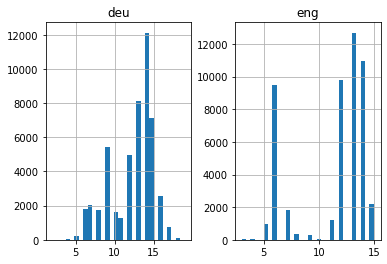

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 200


In [ ]:
# prepare French tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('French Vocabulary Size: %d' % deu_vocab_size)

French Vocabulary Size: 335


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [ ]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

W0707 15:35:08.328547 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 15:35:08.386884 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 15:35:08.403925 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 15:35:09.492994 140575117084480 deprecation.py:323] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be remov

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

W0707 15:35:10.527502 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0707 15:35:10.536232 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

W0707 15:35:12.633531 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 71s 2ms/step - loss: 3.0174 - val_loss: 2.3031

Epoch 00001: val_loss improved from inf to 2.30307, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 69s 2ms/step - loss: 1.9510 - val_loss: 1.6549

Epoch 00002: val_loss improved from 2.30307 to 1.65492, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 77s 2ms/step - loss: 1.5582 - val_loss: 1.4758

Epoch 00003: val_loss improved from 1.65492 to 1.47575, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 88s 3ms/step - loss: 1.2989 - val_loss: 1.1194

Epoch 00004: val_loss improved from 1.47575 to 1.11938, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 91s 3ms/step - loss: 1.1167 - val_loss: 1.1408

Epoch 00005: val_loss did not improve from 1.11938
Epoch 6/30

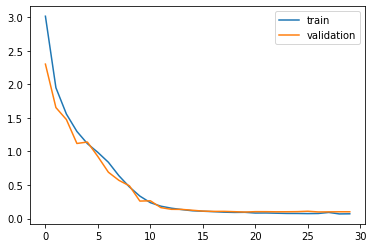

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
preds

array([[43,  7,  3, ..., 68,  2, 33],
       [35,  6,  3, ..., 57,  2, 54],
       [54,  6,  3, ..., 52,  2, 33],
       ...,
       [61,  7,  3, ..., 58,  2, 43],
       [94, 92, 80, ..., 75,  0,  0],
       [13,  6,  5, ..., 30, 14, 15]])

In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [ ]:
preds_text

['april and it is sometimes mild in june',
 'fall but it is never pleasant in march',
 'march but it is sometimes rainy in june',
 'during spring but it is mild in august',
 'during february and it is rainy in november',
 'may but it is sometimes pleasant in autumn',
 'bananas are his most loved fruit  ',
 'during spring and it is beautiful in april',
 'favorite fruit but the apple is our favorite',
 'my favorite animal was the lion  ',
 'april but it is never chilly in winter',
 'during february and it is pleasant in september',
 'winter but it is never mild in january',
 'during spring and it is rainy in april',
 'during winter and it is chilly in fall',
 'february but it is sometimes mild in summer',
 'august and it is usually quiet in spring',
 'fruit but the mango is your most loved',
 'april and it is usually relaxing in fall',
 'he likes limes pears and lemons  ',
 'march and it is sometimes dry in winter',
 'winter and it is never warm in november',
 'fruit but the grapefruit i

In [ ]:
pred_df = pd.DataFrame({'predicted' : preds_text, 'actual' : test[:,0]})

In [ ]:
# print 15 rows randomly
pred_df.sample(15)

,predicted,actual
7549,may but it is usually hot in spring,paris is sometimes busy during may but it is usually warm in spring \n
9669,he likes pears mangoes and lemons,she likes pears mangoes and lemons \n
8311,january and it is usually mild in november,france is sometimes busy during january and it is usually mild in november \n
5060,november but it is never freezing in summer,paris is wet during november but it is never freezing in summer \n
3351,she dislikes bananas mangoes and apples,she dislikes mangoes bananas and apples\n
9264,they dislike grapes lemons and bananas,you dislike grapes lemons and bananas \n
5529,favorite fruit but the lemon is their favorite,the grape is our favorite fruit but the lemon is their favorite \n
9005,may but it is sometimes pleasant in autumn,india is sometimes freezing during june but it is sometimes pleasant in autumn \n
3517,november and it is usually pleasant in fall,china is rainy during autumn and it is usually pleasant in fall \n
4390,you dislike oranges grapes and grapefruit,they dislike oranges grapes and grapefruit \n


In [ ]:
def Average(lst): 
    return sum(lst) / len(lst)
pred_df

,predicted,actual
0,april and it is sometimes mild in june,the united states is busy during april and it is sometimes mild in june \n
1,fall but it is never pleasant in march,china is never hot during fall but it is never nice in march \n
2,march but it is sometimes rainy in june,new jersey is sometimes wonderful during march but it is sometimes rainy in june \n
3,during spring but it is mild in august,paris is never relaxing during december but it is mild in august \n
4,during february and it is rainy in november,california is never busy during february and it is rainy in november \n
5,may but it is sometimes pleasant in autumn,france is never quiet during march but it is sometimes pleasant in autumn \n
6,bananas are his most loved fruit,bananas are her most loved fruit \n
7,during spring and it is beautiful in april,france is wonderful during spring and it is beautiful in april \n
8,favorite fruit but the apple is our favorite,the mango is his favorite fruit but the apple is our favorite \n
9,my favorite animal was the lion,my favorite animal was the lion \n


In [ ]:
import nltk.translate.bleu_score as bleu
bleu_score = list()
for i in range(len(pred_df['predicted'])):
    sl = len(pred_df['predicted'][i])
    last_chars = pred_df['actual'][i][-sl:]
    print(last_chars)
    bleu_score.append(bleu.sentence_bleu(last_chars, pred_df['predicted'][i]))

il  and it is sometimes mild in june 

 fall  but it is never nice in march 

ch  but it is sometimes rainy in june 

g december  but it is mild in august 

ing february  and it is rainy in november 

  but it is sometimes pleasant in autumn 

bananas are her most loved fruit 

ing spring  and it is beautiful in april 

orite fruit  but the apple is our favorite 

my favorite animal was the lion 

il  but it is never chilly in winter 

 during february  and it is nice in september 

ter  but it is never mild in january 

ing spring  and it is rainy in april 

ing winter  and it is chilly in fall 

ruary  but it is sometimes mild in summer 

ust  and it is usually quiet in spring 

it  but the mango is your most loved 

  and it is usually relaxing in autumn 

 likes limes  pears  and lemons 

ch  and it is sometimes dry in winter 

ter  and it is never warm in november 

uit  but the grapefruit is my least favorite

l  but it is usually wet in december 

 likes grapefruit  lemons  and 

like grapes  lemons  and limes 

e dislikes pears  oranges  and grapes 

ing summer  and it is relaxing in april 

why didnt we go to india 

ust  but it is sometimes dry in march 

they went to india 

they dislike grapefruit and peaches 

er most feared animal is this mouse 

ing  and it is usually freezing in may 

ugust  but it is usually cold in december 

uary  and it is sometimes dry in november 

january  and it is usually snowy in fall 

he snake is his most loved animal 

does she like california 

  and it is never dry in fall 

 likes strawberries  grapefruit  and peaches 

tember  and it is sometimes quiet in winter 

n  but it is never busy in summer 

it  but the strawberry is his most loved 

e dislikes lemons  mangoes  and apples 

e like limes  bananas  and pears

 dislike apples  strawberries  and peaches 

ust  and it is sometimes busy in march 

it  but the orange is her least favorite 

e likes strawberries  grapes  and oranges 

 may  but it is usually nice in ja

e likes pears  grapes  and oranges 

y least favorite animal was this elephant 

  and it is sometimes pleasant in march 

ing  and it is usually pleasant in january 

it  but the mango is your least favorite 

il  but it is usually freezing in winter 

 orange  but her favorite is the pear 

g december  and it is cold in autumn 

umn  and it is sometimes hot in may 

e dislikes limes  strawberries  and grapes

ey dislike pears  grapes  and bananas 

ober  and it is usually chilly in spring 

ovember  and it is usually cold in june 

liked that little white automobile 

ch  and it is sometimes mild in summer 

er most loved fruit is the strawberry 

ing summer  and it is hot in june 

ember  but it is never quiet in october 

it  but the mango is your most loved 

 wanted to go to france last october 

ing  and it is usually chilly in december 

e dislikes lemons  pears  and limes 

ing april  and it is chilly in may 

ing  but it is usually snowy in april 

ch  but it is usually busy 

ing october  and it is rainy in autumn 

e dislike apples  strawberries  and grapes 

  but it is sometimes relaxing in december 

ring september  and it is hot in february 

 likes apples  strawberries  and oranges 

me  but her least favorite is the lemon

ember  but it is never hot in november 

ing summer  but it is beautiful in november 

ing december  and it is mild in november 

y dislike apples  lemons  and mangoes 

ring  but it is never hot in april 

pefruit  but her least liked is the grape 

l  but it is usually beautiful in autumn 

vorite fruit  but the pear is his favorite

ing  and it is sometimes dry in january 

is favorite animal is that snake 

anuary  and it is sometimes cold in march 

orite fruit  but the apple is our favorite 

 december  but it is sometimes nice in may 

ing  but it is sometimes chilly in march 

ing spring  but it is wonderful in july 

he drives the little yellow truck 

orite fruit  but the apple is her favorite 

ing december  but it is wo

pefruit  but her least favorite is the lemon 

er  but it is never cold in february 

ing april  and it is wonderful in summer 

 mango  but our favorite is the grapefruit 

 banana  but my favorite is the orange 

il  but it is usually dry in july 

he drove a shiny black truck 

 during october  and it is nice in february 

e wanted to go to california last may 

g autumn  but it is wonderful in october 

e was driving a new red truck 

  but it is usually rainy in fall 

 but it is sometimes pleasant in march 

ing summer  and it is busy in march 

l  but it is sometimes rainy in february 

d a old green automobile 

ember  and it is sometimes busy in april 

l  and it is usually rainy in june 

er  and it is never wonderful in fall 

u dislike pears  strawberries  and mangoes 

that horse was your favorite animal 

  but it is usually chilly in june 

all  and it is sometimes snowy in october 

she likes limes and bananas 

 february  and it is sometimes nice in august 

  but it i

  but it is never cold in spring 

 lime  but his favorite is the strawberry 

ing march  and it is rainy in spring 

ing march  and it is quiet in november 

mer  and it is sometimes snowy in may 

ober  but it is never freezing in march 

 summer  but it is sometimes nice in december 

mer  but it is never quiet in july 

ch  and it is never relaxing in may 

ch  but it is never quiet in december 

ing autumn  but it is mild in may 

she likes big lemons

  but it is never relaxing in january 

  and it is never wonderful in autumn 

she likes the big white truck 

ing january  and it is dry in may 

it  but the grapefruit is my most loved 

it  but the peach is your least favorite 

e plan to visit paris next february 

ing april  and it is quiet in spring 

ing january  and it is wonderful in october 

umn  and it is never beautiful in winter 

e  but it is usually freezing in may 

it  but the orange is their most loved 

e is driving a shiny red car 

ust  but it is usually mild 

awberry  but her least favorite is the lemon 

 orange  but their favorite is the pear 

tember  but it is usually chilly in june 

l  but it is usually hot in january 

ber  and it is never pleasant in autumn 

ch  and it is sometimes warm in november 

tember  and it is never freezing in december 

awberry  but their least favorite is the grapefruit 

dislike apples  mangoes  and strawberries 

ch  but it is sometimes beautiful in january 

 likes limes  pears  and grapes 

ch  and it is never freezing in april 

ober  but it is sometimes quiet in summer 

ember  but it is sometimes hot in august 

go  but his least favorite is the peach 

il  but it is never snowy in october 

 dislike pears  grapefruit  and grapes 

like lemons  apples  and grapefruit 

it  but the strawberry is her most loved 

l  but it is sometimes nice in july 

tember  but it is usually relaxing in april 

we like pears  limes  and bananas 

ruary  and it is never warm in winter 

e  but it is never mild in ja


e  and it is sometimes beautiful in july 

 dislike peaches  grapefruit  and mangoes 

mice were my most loved animals 

il  and it is sometimes wonderful in may 

it  but the apple is her least liked 

 september  but it is usually nice in june 

tember  but it is sometimes warm in july 

she drove a old black automobile 

he likes lemons  peaches  and mangoes

ober  but it is never relaxing in winter 

it  but the lemon is her least favorite 

e  and it is sometimes chilly in may 

hat rabbit was her most feared animal 

 like oranges  apples  and mangoes 

uary  but it is usually warm in august 

umn  but it is usually mild in spring 

he dislikes the rusty yellow car 

  but it is usually rainy in fall 

ing july  and it is beautiful in may 

ey like grapes  limes  and mangoes 

vember  and it is usually chilly in fall 

ing july  but it is pleasant in may 

uary  and it is usually hot in winter 

ly  and it is usually relaxing in fall 

 and it is never warm in autumn 

ember  bu

he went to india last november 

il  and it is usually hot in spring 

y  but it is usually wet in winter 

i like lemons 

e  but it is usually wonderful in may 

she likes apples and pears 

like pears  grapes  and oranges 

 like grapefruit  lemons  and limes 

e likes oranges  lemons  and peaches 

r  but it is usually pleasant in spring 

il  and it is never snowy in february 

orite fruit  but the orange is your favorite 

orite fruit  but the lime is her favorite 

ch  but it is never wonderful in winter 

it  but the strawberry is his least liked 

ing august  and it is mild in february 

ruary  but it is usually dry in summer 

 grape  but my favorite is the strawberry 

ing autumn  but it is busy in october 

apefruit  but her least favorite is the apple

ing april  but it is beautiful in winter 

g june  and it is sometimes quiet in autumn 

mer  but it is usually busy in october 

  and it is never busy in april 

it  but the orange is your least liked 

s she been to franc


it  but the strawberry is her least favorite 

ing  and it is never pleasant in april 

ve a rusty green automobile 

ape  but his least liked is the lime

ing april  and it is chilly in fall 

 plan to visit new jersey in spring 

it  but the lime is your least liked 

ing january  and it is wet in september 

e dislikes oranges  bananas  and peaches 

vember  but it is never hot in january 

e  and it is sometimes quiet in october 

ou like limes  grapefruit  and mangoes

ing spring  but it is quiet in april 

uly  and it is usually cold in june 

ober  and it is sometimes snowy in summer 

nter  but it is usually mild in autumn 

e  and it is never wet in autumn 

e grape  but her favorite is the lime

december  and it is sometimes quiet in fall 

tember  but it is usually dry in summer 

ter  but it is never quiet in april 

 dislikes pears  grapefruit  and limes 

heir least favorite fruit is the banana 

ing august  but it is relaxing in december 

e dislikes grapefruit  pears  


orite fruit  but the apple is your favorite 

it  but the strawberry is their least liked 

uary  and it is sometimes rainy in august 

riving the little black automobile 

ruary  and it is sometimes relaxing in march 

t  but it is never cold in fall 

pefruit  but your most loved is the lime 

y  but it is never snowy in august 

she drove a little green truck 

he saw a rusty blue car 

e  but it is sometimes hot in december 

she likes little strawberries 

ober  but it is usually snowy in september 

ing  and it is sometimes wonderful in june 

une  and it is never snowy in march 

 mangoes  bananas  and grapes 

she dislikes oranges and strawberries 

mer  and it is never mild in january 

tember  but it is usually nice in summer 

ing fall  but it is chilly in november 

uit  but the lemon is our least liked

uring summer  but it is nice in autumn 

he disliked that rusty blue truck 

rch  but it is sometimes relaxing in fall 

orite fruit  but the apple is your favorite 

mang


e likes mangoes  grapes  and pears 

ing february  but it is wonderful in october 

ober  but it is usually rainy in june 

 likes strawberries  limes  and apples 

 strawberry  but her favorite is the grape 

 grapefruit  but their favorite is the peach 

ring november  but it is hot in august 

  but it is sometimes beautiful in september 

it  but the mango is our most loved 

ana  but my most loved is the mango 

pefruit  but my most loved is the grape 

he disliked a big white truck 

 lemon  but his favorite is the mango 

ou dislike grapes  apples  and peaches 

it  but the mango is our least liked 

e dislikes bananas  lemons  and grapes 

he liked a big blue automobile 

ing fall  but it is mild in april 

e like limes  grapes  and strawberries

i like apples  limes  and peaches 

orite fruit  but the strawberry is their favorite 

 peach  but your favorite is the lemon 

l  but it is usually mild in winter 

ember  but it is never pleasant in winter 

ing october  but it is 

ing april  and it is beautiful in summer 

ing  but it is never chilly in april 

e  and it is usually quiet in winter 

e likes oranges  mangoes  and limes 

uary  but it is never chilly in september 

ember  but it is usually freezing in autumn 

orite fruit  but the lime is his favorite 

he plans to visit paris in winter 

ing may  but it is dry in september 

 dislike mangoes  grapefruit  and strawberries

le  but your most loved is the grapefruit 

il  but it is usually hot in march 

but it is usually pleasant in october 

ing december  but it is chilly in november 

she drove a little white truck 

ch  but her least favorite is the grape 

but it is usually pleasant in june 

ng fall  but it is warm in june 

y  and it is usually chilly in december 

ember  but it is never beautiful in november 

it  but the grapefruit is their least liked 

she saw the rusty blue car 

e  but it is sometimes mild in summer 

 likes strawberries  grapefruit  and apples 

why did you go to calif

e  and it is never dry in summer 

  and it is never wonderful in autumn 

ing june  but it is freezing in august 

she liked that rusty white truck 

ter  and it is usually hot in april 

 likes grapefruit  lemons  and apples 

ing march  but it is warm in february 

ctober  but it is sometimes cold in november 

this shark is your favorite animal 

e  but our most loved is the strawberry 

ust  and it is never mild in january 

y  but it is usually pleasant in december 

ember  and it is never freezing in october 

she likes grapefruit and limes 

ter  and it is never hot in december 

nge  but our least favorite is the grape 

  and it is never hot in autumn 

ing april  but it is dry in october 

l  and it is sometimes chilly in winter 

  but it is usually rainy in fall 

ing  but it is sometimes wonderful in april 

nter  but it is usually mild in autumn 

uary  but it is usually wonderful in summer 

they dislike peaches and bananas 

ana  but my most loved is the lemon 

ember 

ing january  and it is rainy in march 

ng winter  and it is usually nice in fall 

ember  and it is never warm in february 

orite fruit  but the strawberry is his favorite 

ing may  and it is wet in spring 

y  but it is sometimes quiet in august 

ruary  but it is never snowy in summer 

ember  but it is sometimes dry in spring 

rawberry  but their least liked is the grapefruit

umn  and it is never dry in november 

e  and it is never relaxing in january 

ing march  and it is rainy in august 

  but it is never warm in march 

ring spring  but it is hot in june 

ut it is sometimes pleasant in april 

y  and it is never wet in may 

ng december  and it is warm in march 

it  but the lemon is her least favorite 

  but it is usually pleasant in fall 

ing april  but it is wet in september 

ing march  and it is dry in june 

ing june  but it is dry in april 

dislike apples  bananas  and oranges 

ing spring  but it is quiet in january 

 october  and it is sometimes nice in summ


he is driving a shiny green car 

ing july  and it is dry in june 

y  but it is sometimes freezing in october 

 dislikes strawberries  grapefruit  and limes 

ing december  but it is chilly in winter 

ey dislike pears  limes  and apples 

ing summer  but it is wonderful in february 

ing april  but it is chilly in summer 

all  but it is sometimes rainy in june 

he plans to visit france in july 

ember  but it is never rainy in summer 

he was driving a big blue car 

ember  and it is never quiet in summer 

ch  but my most loved is the apple 

ing july  but it is snowy in spring 

uary  but it is usually warm in august 

go  but your least favorite is the pear 

e  but it is never freezing in september 

we like oranges  bananas  and limes 

  but it is sometimes snowy in november 

e  but it is sometimes wonderful in december 

ve a old blue automobile 

ober  but it is usually hot in september 

 but it is never rainy in autumn 

ril  and it is never hot in july 

y like banana

ing february  and it is beautiful in july 

u think translating between spanish and portuguese is fun 

 but it is sometimes pleasant in may 

 likes strawberries  limes  and apples 

orite fruit  but the lime is her favorite 

dislike pears  grapes  and apples 

 november  but it is never nice in march 

il  and it is usually busy in spring 

an to visit the united states next may 

ing may  but it is pleasant in summer 

uit  but the grapefruit is our least liked

ruary  but it is sometimes wonderful in autumn 

it  but the grapefruit is my most loved 

ust  and it is sometimes snowy in summer 

tember  but it is never dry in spring 

ust  and it is never snowy in september 

il  and it is sometimes quiet in october 

n  but it is usually dry in september 

es a rusty white automobile 

e dislikes limes  pears  and oranges

ing november  and it is wet in august 

she liked that shiny black truck 

  but it is never cold in october 

mer  but it is sometimes rainy in may 

hey plan to

e grape  but our favorite is the peach

rch  and it is never pleasant in autumn 

it  but the grape is her most loved 

nge  but his most loved is the pear 

ter  and it is never cold in may 

ust  but it is never wet in may 

ey dislike bananas  limes  and lemons 

he dislikes strawberries and grapefruit 

tember  and it is never hot in winter 

uit  but the pear is our least favorite

ber  and it is sometimes warm in fall 

e dislikes grapefruit  mangoes  and oranges 

ana  but their least favorite is the lime 

une  and it is usually cold in summer 

  and it is usually quiet in july 

all  and it is sometimes rainy in march 

it  but the grape is their least liked 

it  but the mango is our least favorite 

she likes grapefruit and apples 

ing autumn  but it is wonderful in july 

ou like pears  limes  and bananas 

 likes grapefruit  limes  and bananas 

orite fruit  but the strawberry is his favorite 

ing august  and it is dry in autumn 

i dislike pears  lemons  and peaches 




ter  and it is usually relaxing in april 

il  but it is usually chilly in july 

ch  and it is usually mild in october 

n  but it is usually hot in october 

ey wanted to go to california last summer 

ter  but it is usually busy in april 

ember  but it is sometimes rainy in april 

umn  but it is sometimes pleasant in june 

they went to paris last december 

 september  but it is never nice in february 

 during september  and it is nice in april 

l  and it is sometimes pleasant in spring 

uary  and it is never quiet in july 

pefruit  but their least favorite is the lime 

ing march  and it is quiet in october 

e  but our most loved is the pear 

 dislikes bananas  peaches  and mangoes 

pe  but our most loved is the lemon 

he likes apples  limes  and grapes 

you dislike peaches and oranges 

drives the shiny green car 

e plan to visit paris next winter 

il  but it is usually wet in november 

g august  but it is mild in autumn 

l  but it is never mild in may 

ber  and 

is most feared animal was that cat 

umn  but it is usually quiet in november 

r  but their least liked is the mango 

 june  and it is sometimes freezing in september 

 likes pears  strawberries  and bananas 

e likes oranges  mangoes  and grapefruit 

il  and it is usually dry in may 

it  but the grapefruit is my most loved 

 like grapes  bananas  and pears 

il  but it is never warm in june 

it  but the apple is your most loved 

ust  and it is sometimes busy in october 

ruary  but it is sometimes wonderful in winter 

ruary  and it is sometimes snowy in november 

  but it is never cold in april 

y  and it is usually freezing in summer 

ing fall  and it is cold in may 

 grapefruit  but my favorite is the banana 

hey are going to france next september 

ust  but it is usually relaxing in april 

ober  but it is usually warm in march 

e likes limes  oranges  and lemons 

pril  and it is usually cold in winter 

 dislikes limes  grapes  and bananas

e like limes  grapefruit


ober  and it is never beautiful in august 

s bananas  limes  and strawberries 

ing  but it is never mild in november 

ana  but his least favorite is the grape 

ter  but it is usually freezing in spring 

it  but the mango is your most loved 

he went to france last winter 

ing march  and it is dry in winter 

ring september  and it is hot in march 

ust  and it is usually dry in summer 

e likes lemons  mangoes  and grapefruit

 likes pears  grapes  and limes 

ing december  but it is rainy in february 

e dislikes grapefruit  limes  and grapes 

ruary  but it is never busy in fall 

ing summer  but it is quiet in september 

he dislikes big grapes

y  but it is sometimes freezing in winter 

pefruit  but his least liked is the apple 

rawberry  but our least liked is the apple

e  and it is usually beautiful in december 

 winter  and it is usually nice in september 

ring autumn  but it is hot in august 

arch  and it is usually cold in october 

il  and it is sometimes busy in


 orange  but your favorite is the grape 

mer  and it is usually nice in autumn 

ing january  but it is dry in february 

i dislike bananas  oranges  and grapes 

ember  and it is sometimes wet in winter 

ch  but our most loved is the grape 

he likes lemons  limes  and pears

they dislike lemons and oranges 

 pear  but your favorite is the strawberry 

it  but the mango is our least liked 

mer  but it is never mild in october 

ur most feared animal is that shark 

e  and it is never busy in january 

ing may  but it is freezing in january 

e  but it is sometimes rainy in autumn 

ey like apples  lemons  and oranges 

his favorite animal is the horse 

awberry  but my least favorite is the banana 

tember  but it is usually warm in july 

  but it is never cold in march 

  but it is usually rainy in fall 

orite fruit  but the pear is our favorite 

r  but your least favorite is the strawberry 

it  but the peach is their most loved 

uit  but the grapefruit is his least liked


ing february  and it is beautiful in autumn 

il  and it is usually quiet in october 

e  but it is never quiet in october 

y  but it is usually rainy in spring 

me  but your most loved is the strawberry

ter  but it is usually busy in march 

like apples  grapefruit  and oranges 

e dislikes peaches  oranges  and apples 

ing summer  but it is relaxing in september 

ch  but their least favorite is the grapefruit 

he saw a shiny yellow truck 

 winter  but it is never nice in june 

orite fruit  but the orange is my favorite 

ing november  but it is relaxing in summer 

ey dislike bananas  grapefruit  and grapes 

ember  but it is usually pleasant in november 

 might go to china next autumn 

ary  but it is sometimes busy in fall 

but it is usually pleasant in autumn 

 banana  but my favorite is the grapefruit 

y  but it is never snowy in september 

 april  and it is usually nice in july 

she dislikes bananas and pears 

ing march  but it is snowy in november 

ing spring  a

his dog is your least favorite animal 

bears are her most loved animals 

 during september  and it is nice in summer 

e dislikes lemons  peaches  and oranges 

ing  but it is never rainy in july 

y  and it is never beautiful in spring 

on  but her least liked is the grapefruit 

e likes oranges  apples  and grapes 

ober  but it is usually mild in winter 

mer  and it is usually snowy in winter 

he liked the rusty white truck 

our most loved animal is this shark 

ember  and it is never quiet in september 

ing  and it is sometimes quiet in summer 

ing october  but it is wonderful in june 

ter  but it is never snowy in april 

 likes limes  apples  and lemons 

tember  and it is never relaxing in february 

 dislikes limes  grapefruit  and oranges

ey dislike grapefruit  apples  and oranges 

ing april  but it is cold in july 

dislikes bananas  lemons  and pears 

uary  but it is sometimes wet in june 

e likes oranges  mangoes  and pears 

 dislikes mangoes  limes  and straw

it  but the mango is his least liked 

  but it is never dry in spring 

it  but the orange is his least liked 

ter  and it is never wonderful in november 

e  but his least liked is the strawberry 

n  and it is sometimes dry in summer 

g fall  but it is rainy in autumn 

ing spring  but it is quiet in november 

 november  but it is usually nice in september 

e grape  but her favorite is the apple

ey dislike grapefruit  pears  and grapes 

u like lemons  peaches  and mangoes 

orite fruit  but the apple is your favorite 

ust  and it is usually hot in july 

y most feared animal is this dog 

our least favorite animal was that lion 

mer  but it is sometimes mild in december 

e  but it is sometimes rainy in july 

rabbits were his least favorite animals 

ruary  but it is sometimes busy in october 

e  but her least liked is the grape 

ing spring  and it is rainy in may 

ring  and it is sometimes hot in summer 

  but it is usually wonderful in fall 

ing september  and it is 


ober  and it is usually nice in autumn 

it  but the peach is my least favorite 

ing december  but it is busy in november 

e  and it is never rainy in july 

apples  peaches  and strawberries 

uit  but the strawberry is his least liked

ring january  and it is hot in autumn 

i dislike pears  limes  and grapefruit 

ing autumn  and it is mild in spring 

ember  and it is usually busy in november 

 peach  but his favorite is the grape 

ober  but it is usually quiet in june 

  and it is usually nice in august 

dislikes limes  bananas  and peaches 

it  but the lemon is our least favorite 

 during july  but it is nice in spring 

ember  but it is never snowy in june 

n  and it is never chilly in october 

uary  but it is never busy in december 

mer  and it is never chilly in december 

e dislikes lemons  mangoes  and strawberries 

ter  but it is sometimes relaxing in february 

e like mangoes  bananas  and strawberries

pring  but it is sometimes cold in march 

n  and it is u

 dislike apples  strawberries  and grapefruit 

e likes grapefruit  bananas  and apples 

she drives the shiny green car 

ust  and it is usually quiet in may 

ust  but it is never wonderful in april 

mer  and it is never rainy in august 

uary  but it is sometimes relaxing in june 

ch  and it is never wonderful in november 

ober  but it is sometimes quiet in june 

 during january  and it is nice in september 

ch  and it is usually pleasant in december 

ing  and it is sometimes freezing in march 

she drove the shiny white car 

mer  and it is never warm in february 

uring july  but it is quiet in fall 

ruary  but it is sometimes busy in winter 

le  but their least favorite is the lime 

il  but it is sometimes dry in february 

l  and it is never hot in february 

ing winter  and it is wet in september 

 dislikes peaches  mangoes  and lemons 

ring fall  but it is hot in february 

t  but your least liked is the grape 

he drove a rusty green car 

arch  and it is usually c


ember  and it is never rainy in april 

il  but it is never chilly in january 

i dislike limes  bananas  and peaches

ng may  but it is warm in august 

 fall  but it is usually nice in april 

ng summer  but it is warm in may 

ust  but it is never rainy in june 

e  but it is sometimes snowy in july 

umn  but it is usually beautiful in august 

n  but it is usually busy in september 

our least favorite animal was that rabbit 

mice were his least favorite animals 

  but it is never rainy in fall 

orite fruit  but the lime is her favorite 

ember  and it is usually hot in april 

he likes grapes  bananas  and oranges

pril  but it is never hot in autumn 

ey dislike bananas  lemons  and grapes 

inter  but it is usually cold in april 

 during september  but it is nice in march 

e  and it is usually quiet in february 

ch  and it is sometimes dry in summer 

ng fall  and it is sometimes nice in june 

ember  but it is sometimes beautiful in november 

ter  and it is usually rel

mer  but it is never hot in december 

ana  but your least liked is the mango 

e likes grapefruit  bananas  and grapes 

ember  but it is never chilly in october 

ing september  and it is mild in march 

tember  and it is never hot in march 

e dislikes lemons  grapefruit  and bananas 

ng may  and it is warm in summer 

go  but his most loved is the lime 

i dislike strawberries  limes  and apples 

ch  and it is never snowy in december 

ing may  but it is cold in fall 

ing october  and it is rainy in summer 

ing january  but it is busy in july 

 grapefruit  but my favorite is the peach 

my favorite animals were cats 

 dislike lemons  grapes  and peaches 

nge  but her least liked is the peach 

ing summer  but it is relaxing in fall 

n  and it is never pleasant in january 

y  and it is sometimes rainy in march 

ter  and it is sometimes relaxing in july 

ober  and it is never relaxing in december 

  but it is never busy in december 

e dislikes bananas  apples  and lemons


all  and it is sometimes snowy in autumn 

ust  but it is usually beautiful in summer 

e likes strawberries  bananas  and mangoes 

inter  but it is sometimes cold in january 

ring september  and it is hot in july 

g november  but it is busy in autumn 

august  but it is usually mild in fall 

 likes bananas  apples  and lemons 

ch  but it is never wet in august 

pril  but it is usually freezing in fall 

e  but their most loved is the apple 

ing spring  and it is cold in october 

orses were your least favorite animals 

orite fruit  but the orange is his favorite 

ing spring  but it is rainy in summer 

tember  but it is usually chilly in april 

ter  but it is sometimes chilly in january 

ing november  but it is pleasant in june 

mer  and it is usually dry in december 

ch  and it is never wonderful in january 

dislike apples  mangoes  and lemons 

ter  but it is never warm in autumn 

orite fruit  but the orange is her favorite 

ey dislike grapefruit  lemons  and orange

i dislike bananas  mangoes  and peaches 

ober  but it is never relaxing in summer 

 like strawberries  bananas  and oranges 

orite fruit  but the orange is our favorite 

ing june  but it is busy in may 

go  but his least favorite is the lime 

ember  but it is sometimes dry in september 

ing september  and it is quiet in january 

he disliked that new white truck 

it  but the apple is my least liked 

orite fruit  but the mango is their favorite 

 orange  but their favorite is the grapefruit 

ember  and it is usually wet in april 

she drove a new green truck 

tember  but it is never rainy in may 

she likes a big green automobile 

mer  but it is never beautiful in spring 

all  and it is usually relaxing in july 

tember  but it is sometimes beautiful in october 

he likes strawberries and oranges 

r  but it is sometimes relaxing in autumn 

uit  but the peach is their most loved

ch  but it is usually warm in january 

ing october  and it is chilly in december 

he lime i


ing  but it is never freezing in winter 

y  but it is usually chilly in summer 

it  but the grapefruit is your least liked 

it  but the strawberry is her least favorite 

il  and it is usually rainy in june 

it  but the pear is their most loved 

l  and it is sometimes quiet in march 

i like oranges and pears 

on  but their most loved is the strawberry 

she dislikes bananas and grapes 

ober  but it is usually rainy in december 

ing january  and it is wet in november 

 june  but it is sometimes freezing in september 

ing december  and it is pleasant in august 

ust  but it is sometimes quiet in december 

 apple  but his favorite is the orange 

 and it is usually pleasant in may 

er  and it is never snowy in february 

n  but it is usually beautiful in december 

e dislikes bananas  limes  and pears 

dislikes mangoes  pears  and oranges 

ober  but it is never dry in winter 

mer  and it is never mild in may 

ur least favorite fruit is the grapefruit 

ing october  and i

march  and it is never pleasant in fall 

l  but it is never busy in september 

tember  but it is usually hot in december 

ing  but it is sometimes relaxing in july 

he disliked a little green car 

he likes grapes  oranges  and limes

orite fruit  but the lime is their favorite 

ober  but it is sometimes busy in spring 

he saw that little green car 

orite fruit  but the mango is their favorite 

u like pears  grapefruit  and grapes 

ing april  but it is beautiful in winter 

 grapefruit  but her favorite is the apple 

e likes peaches  limes  and grapes 

 but it is never cold in autumn 

tember  and it is never quiet in november 

u dislike grapes  oranges  and apples 

e dislikes apples  peaches  and strawberries 

he likes lemons  oranges  and grapes

uit  but the lemon is his least liked

orite fruit  but the grape is his favorite 

pefruit  but his least liked is the grape 

uit  but the mango is his least favorite

he plans to visit china next december 

ugust  and it is 


tember  and it is never rainy in march 

you dislike bananas and peaches 

mer  and it is sometimes warm in february 

uary  and it is sometimes wet in august 

she disliked a shiny red car 

nge  but their least liked is the peach 

  but it is never cold in winter 

 september  and it is never nice in july 

 dislikes pears  bananas  and grapefruit 

ing  and it is usually freezing in december 

u dislike grapefruit  mangoes  and oranges 

ober  and it is usually wet in july 

ing  and it is usually freezing in winter 

uary  and it is usually beautiful in july 

ust  but it is sometimes snowy in july 

ter  and it is never dry in march 

she likes peaches  oranges  and lemons 

e  and it is usually mild in july 

e was driving that big red truck 

y  and it is never hot in march 

ember  but it is usually beautiful in january 

uary  and it is sometimes mild in july 

all  but it is sometimes dry in may 

ing august  but it is pleasant in january 

ing march  but it is freezing in 


ves that old red automobile 

orite fruit  but the mango is his favorite 

 dislike pears  grapefruit  and oranges 

we like limes and grapefruit

y arent they going to the football field 

il  and it is sometimes wonderful in august 

i dislike strawberries  peaches  and grapes 

it  but the pear is their least liked 

 february  and it is never nice in october 

orite fruit  but the apple is her favorite 

e dislikes grapefruit  pears  and limes 

  but it is usually beautiful in february 

orite fruit  but the grape is her favorite 

ing august  and it is wet in april 

y  but it is sometimes freezing in april 

pril  but it is sometimes cold in winter 

all  and it is sometimes wet in november 

ing january  but it is snowy in july 

ing february  but it is wonderful in august 

ing  but it is usually wonderful in winter 

ing december  and it is dry in spring 

ing may  and it is beautiful in winter 

on  but her least favorite is the banana 

n  but it is never dry in june 

ori

  and it is usually relaxing in autumn 

icult to translate between chinese and spanish 

iked the old blue automobile 

ing november  and it is wonderful in december 

ing august  and it is wet in may 

 peach  but their favorite is the mango 

l  but it is never chilly in august 

er most loved fruit is the orange 

ch  and it is usually snowy in january 

but it is usually quiet in autumn 

rawberry  but her least liked is the apple

y dislike oranges  lemons  and pears 

ing april  and it is pleasant in january 

ou like limes  pears  and apples

ana  but their most loved is the grape 

uary  but it is never dry in march 

ing march  and it is relaxing in spring 

ing spring  but it is mild in november 

it  but the lime is her most loved 

ing september  but it is wonderful in october 

ey dislike peaches  strawberries  and mangoes 

n  but it is usually snowy in december 

e dislikes grapes  pears  and peaches 

 dislike oranges  pears  and strawberries 

il  and it is sometimes 


ember  but it is usually chilly in january 

her least favorite animals were horses 

uary  and it is usually wonderful in winter 

pefruit  but their most loved is the apple 

pefruit  but his most loved is the banana 

it  but the lime is my least favorite 

y  but it is sometimes relaxing in autumn 

ey want to go to france next march 

mer  and it is never quiet in june 

ing summer  but it is hot in february 

ing january  and it is rainy in september 

 plan to visit france in march 

ey dislike oranges  pears  and limes 

ing  and it is never wet in winter 

ing january  but it is quiet in winter 

ary  but it is sometimes warm in august 

he likes lemons  pears  and grapes

it  but the grape is your most loved 

hat snake is my most loved animal 

e grape  but his favorite is the grapefruit

nge  but my least liked is the mango 

they went to paris last summer 

 september  and it is never nice in february 

ter  and it is never rainy in august 

ugust  and it is never busy in

mer  but it is sometimes dry in may 

s difficult to translate spanish to french 

ana  but her least liked is the peach 

tober  and it is sometimes hot in april 

he likes limes and lemons 

all  and it is usually busy in november 

il  and it is sometimes wonderful in autumn 

e likes mangoes  pears  and grapes 

s the weather in new jersey last winter 

mer  but it is never snowy in winter 

 july  but it is usually nice in june 

e  but it is usually dry in january 

y  and it is usually wonderful in october 

 january  but it is never nice in may 

ey dislike limes  peaches  and lemons

he likes grapes  mangoes  and bananas

ing september  but it is wonderful in january 

he dislikes lemons  grapes  and bananas

pe  but her least favorite is the mango 

umn  but it is never snowy in summer 

pe  but my most loved is the pear 

i dislike oranges  strawberries  and pears 

 plan to visit india next summer 

  and it is sometimes pleasant in august 

it  but the orange is our least 

 peach  but our favorite is the lime 

s translating between portuguese and english is difficult 

ing october  and it is cold in may 

he drove that little green car 

it  but the banana is her least favorite 

ember  and it is usually mild in january 

ing autumn  but it is mild in december 

  but it is never cold in summer 

ey like oranges  limes  and apples 

 bananas  mangoes  and pears 

ch  but his most loved is the apple 

ing february  but it is quiet in june 

all  but it is sometimes chilly in june 

e wants to go to india next december 

 mangoes  bananas  and pears 

ing autumn  and it is mild in february 

ober  and it is usually busy in winter 

slikes mangoes  limes  and bananas 

islikes mangoes  grapefruit  and grapes 

 go to the united states next july 

r  and it is sometimes warm in autumn 

il  but it is usually busy in summer 

you like lemons and oranges 

ing  but it is sometimes snowy in august 

e  but our least favorite is the grapefruit 

 dislikes peach

er  and it is sometimes hot in autumn 

ember  and it is never hot in spring 

ing october  but it is quiet in march 

he likes grapefruit and strawberries 

ember  but it is never wonderful in june 

anslating between french and spanish is easy 

 dislikes strawberries  peaches  and apples 

it  but the grape is my least favorite 

 dislikes limes  pears  and bananas 

he dislikes mangoes and lemons 

 likes peaches  grapefruit  and grapes 

orite fruit  but the peach is your favorite 

g winter  and it is chilly in autumn 

it  but the grape is their least favorite 

ing july  but it is rainy in may 

ing  but it is sometimes busy in march 

ch  but it is usually dry in february 

ing april  and it is pleasant in december 

mer  but it is sometimes rainy in winter 

ing fall  but it is rainy in winter 

mmer  but it is sometimes hot in spring 

ust  but it is usually chilly in september 

she disliked a shiny black car 

like oranges  grapefruit  and pears 

 dislikes strawberries  g

In [ ]:
print("la précision de ce modele est de ", Average(bleu_score))

la précision de ce modele est de  1.437502584848792e-231


NameError: name 'bleu_sc' is not defined